In [1]:
import gc_utils
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
sim = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"

snap_pub_dir = sim_dir + "/snapshot_times_public.txt"
snap_pub_data = pd.read_table(snap_pub_dir, comment="#", header=None, sep=r"\s+")
snap_pub_data.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

snp_lst = snap_pub_data["index"].values
tim_lst = snap_pub_data["time_Gyr"].values

sim = "m12c"

it = 100
it_id = gc_utils.iteration_name(it)

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

In [3]:
class GlobularCluster:
    def __init__(self, gc_id, group_id, mass_init, tform, tdis, tacc):
        self.gc_id = gc_id
        self.group_id = group_id
        self.mass_init = mass_init
        self.tform = tform
        self.tdis = tdis
        self.tacc = tacc

        self.mass_init_evolve = 0.55 * mass_init
        self.survive_z0 = 1 if tdis == -1 else 0
        self.survive_accretion = 0 if self.group_id < 0 else 1

        self.masses = {}  # {snap: mass}
        self.radii = {}  # {snap: radius}
        self.tidems = {}  # {snap: tidem}

        self.ages = {}  # {snap: age}

        # for ex-situ GCs only
        # self.radii_pre_acc = {}
        # self.radii_pos_acc = {}

        self.weighted_radius = None
        self.weighted_tidems = None

        # self.weighted_radius_pre_acc = None
        # self.weighted_radius_pos_acc = None

    def add_snapshot(self, snap, mass, radius, tidem, age):
        self.masses[snap] = mass
        self.radii[snap] = radius
        self.tidems[snap] = tidem
        self.ages[snap] = age

    def add_variable_rad(self, snap, radius, timing: str = "pre"):
        if timing == "pre":
            self.radii_pre_acc[snap] = radius
        elif timing == "pos":
            self.radii_pos_acc[snap] = radius

    def add_weighted_radius(self, weights):
        radii = np.array([self.radii[snap] for snap in self.radii])
        msk = ~np.isnan(radii)

        if msk.sum() == 0:
            self.weighted_radius = np.nan
        else:
            self.weighted_radius = np.average(radii[msk], weights=weights[msk])
        # return self.weighted_radius

    def add_weighted_tidems(self, weights):
        tidems = np.array([self.tidems[snap] for snap in self.tidems])
        msk = ~np.isnan(tidems)

        if msk.sum() == 0:
            self.weighted_tidems = np.nan
        else:
            self.weighted_tidems = np.average(tidems[msk], weights=weights[msk])
        # return self.weighted_radius

In [4]:
# As potentials difficult to define at early times and hence early values of r_apo, r_per are error prone, we
# use r values rather than (r_apo + r_per) / 2 to define average radial extent.

src_dat = proc_data[it_id]["source"]
msk = src_dat["analyse_flag"][()] == 1

# if group == "in_situ":
#     grp_msk = src_dat["group_id"][()] == 0
# elif group == "ex_situ":
#     grp_msk = src_dat["group_id"][()] != 0
# else:
#     grp_msk = np.ones(len(ana_msk), dtype=bool)

# msk = ana_msk & grp_msk

gc_lst = src_dat["gc_id"][msk]
group_lst = src_dat["group_id"][msk]
mass_init_lst = 10 ** src_dat["logm_tform"][msk]
tform_lst = src_dat["form_time"][msk]
tdis_lst = src_dat["t_dis"][msk]
tacc_lst = src_dat["t_acc"][msk]

In [5]:
gc_dict = {}
for i, gc_id in enumerate(gc_lst):
    gc_dict[gc_id] = GlobularCluster(
        gc_id, group_lst[i], mass_init_lst[i], tform_lst[i], tdis_lst[i], tacc_lst[i]
    )

In [6]:
for j, snap in enumerate(snp_lst):
    snap_id = gc_utils.snapshot_name(snap)
    snp_dat = proc_data[it_id]["snapshots"][snap_id]

    snap_gc_ids = snp_dat["gc_id"][()]
    radii_snap = snp_dat["r"][()]
    masses_snap = 10 ** snp_dat["mass"][()]
    tidems_snap = snp_dat["tideig_1"][()] - snp_dat["tideig_3"][()]
    time = tim_lst[j]

    # Build lookup dictionary: gc_id -> index in snapshot arrays
    gc_index_map = {gid: idx for idx, gid in enumerate(snap_gc_ids)}

    for gc_id in gc_lst:  # loop over all GCs
        if gc_id in gc_index_map:
            idx = gc_index_map[gc_id]
            radius = radii_snap[idx]
            mass = masses_snap[idx]
            tidem = tidems_snap[idx]
            age = time - gc_dict[gc_id].tform

            # if gc_dict[gc_id].group_id != 0:
            #     tacc = gc_dict[gc_id].tacc
            #     if time < tacc:
            #         halo_r_pre = snp_dat["halo.r"][idx]
            #         halo_r_pos = np.nan
            #     else:
            #         halo_r_pre = np.nan
            #         halo_r_pos = snp_dat["r"][idx]

        else:
            radius = np.nan
            mass = np.nan
            tidem = np.nan
            age = np.nan
            # halo_r_pre = np.nan
            # halo_r_pos = np.nan

        gc_dict[gc_id].add_snapshot(snap, mass, radius, tidem, age)

        # if gc_dict[gc_id].group_id != 0:
        #     gc_dict[gc_id].add_variable_rad(snap, halo_r_pre, timing="pre")
        #     gc_dict[gc_id].add_variable_rad(snap, halo_r_pos, timing="pos")

for gc in gc_dict.values():
    gc.add_weighted_radius(tim_lst)
    gc.add_weighted_tidems(tim_lst)

# self.radii_pre_acc = {}
# self.radii_pos_acc = {}

In [7]:
in_sur_dict = {"mass_init": [], "avg_rad": [], "avg_tidem": []}
in_dea_dict = {"mass_init": [], "avg_rad": [], "avg_tidem": [], "tdis": []}

for gc in gc_dict.values():
    if gc.group_id == 0:
        if gc.survive_z0 == 1:
            in_sur_dict["mass_init"].append(gc.mass_init)
            in_sur_dict["avg_rad"].append(gc.weighted_radius)
            in_sur_dict["avg_tidem"].append(gc.weighted_tidems)
        else:
            in_dea_dict["mass_init"].append(gc.mass_init)
            in_dea_dict["avg_rad"].append(gc.weighted_radius)
            in_dea_dict["avg_tidem"].append(gc.weighted_tidems)
            in_dea_dict["tdis"].append(gc.tdis - gc.tform)

Text(0, 0.5, 'Average Radius (kpc)')

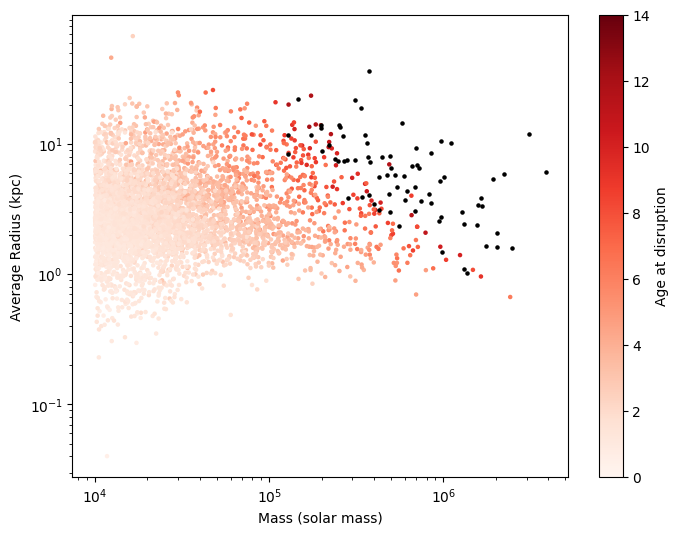

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(
    in_dea_dict["mass_init"], in_dea_dict["avg_rad"], c=in_dea_dict["tdis"], vmin=0, vmax=14, s=5, cmap="Reds"
)

# What is more appropriate, age of disruption or time of disruption?
plt.colorbar(label="Age at disruption")
plt.scatter(in_sur_dict["mass_init"], in_sur_dict["avg_rad"], c="k", s=5)


plt.xscale("log")
plt.yscale("log")

plt.xlabel("Mass (solar mass)")
plt.ylabel("Average Radius (kpc)")

Okay, need to write a function that takes part as a variable and then from there go through each iteration at the corresponding snapshot and find distance of GC from DM centre of galaxy pre accretion. Irritating but necessary. Define, pre accretion conditions. Okay get pos and vel in spherical. Don't do cartesian. Too hard to define the principle axis of the previous host. 

In [9]:
gc.__dict__.keys()

dict_keys(['gc_id', 'group_id', 'mass_init', 'tform', 'tdis', 'tacc', 'mass_init_evolve', 'survive_z0', 'survive_accretion', 'masses', 'radii', 'tidems', 'ages', 'weighted_radius', 'weighted_tidems'])

Text(0, 0.5, 'Mass at z=0 (M$_\\odot$)')

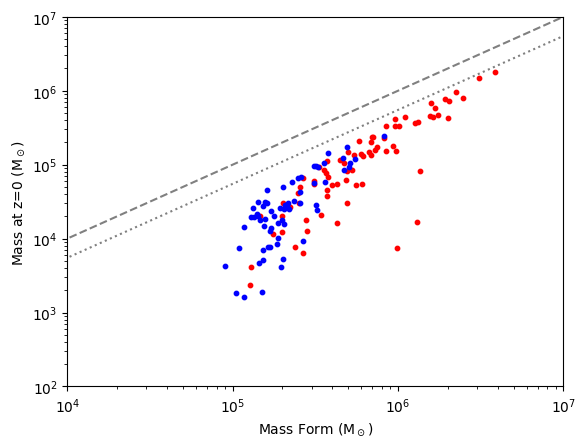

In [10]:
x = []
y = []
c = []

for gc in gc_dict.values():
    if gc.survive_z0 == 1:
        x.append(gc.mass_init)
        y.append(gc.masses[600])

        if gc.group_id == 0:
            c.append(0)
        else:
            c.append(1)

x = np.array(x)
y = np.array(y)
c = np.array(c)

acc_msk = c == 1

plt.scatter(x[~acc_msk], y[~acc_msk], c="r", s=10)
plt.scatter(x[acc_msk], y[acc_msk], c="b", s=10)
plt.plot([10**2, 10**7], [10**2, 10**7], c="grey", ls="--")
plt.plot([10**2, 10**7], 0.55 * np.array([10**2, 10**7]), c="grey", ls="dotted")

plt.xlim(10**4, 10**7)
plt.ylim(10**2, 10**7)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"Mass Form (M$_\odot$)")
plt.ylabel(r"Mass at z=0 (M$_\odot$)")

In [11]:
proc_data["it000"]["snapshots"]["snap102"].keys()

<KeysViewHDF5 ['acc_snap', 'bound_flag', 'ecc', 'ek', 'ep_agama', 'ep_fire', 'et', 'et_norm', 'gc_id', 'group_id', 'halo.pos.cyl', 'halo.pos.xyz', 'halo.r', 'halo.vel.cyl', 'halo.vel.xyz', 'halo_zform', 'inc', 'j.cyl', 'l.xyz', 'lz_norm', 'mass', 'now_accreted', 'pos.cyl', 'pos.sph', 'pos.xyz', 'ptype', 'r', 'r_apo', 'r_per', 'snap_part_idx', 'survive_flag', 'survived_accretion', 'tideig_1', 'tideig_2', 'tideig_3', 'tideig_m', 'vel.cyl', 'vel.sph', 'vel.xyz']>